# Template Attack

In [2]:
import h5py
import numpy as np
import leakage_models
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import os.path
import tensorflow as tf
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow.keras as tk
import tensorflow.keras.layers as tkl
from sklearn.model_selection import train_test_split


# Choose a leakage model
LEAKAGE_MODEL = leakage_models.identity_sbox

# Choose the number of features (points of interest)
NUM_FEATURES = 32

## Loading data

label:        96
plaintext:    [135 117 158  27 216 215 215 164  92  57 156  57  10 140 192 219]
key:          [167 113  14 152  65  46  81 123 144 167 244  95 192  65  94 193]
masks:        [  0   0 106 250  10 124 208 143 123  14 197 189 228 239 199   9  11 163]
desync:       [0]


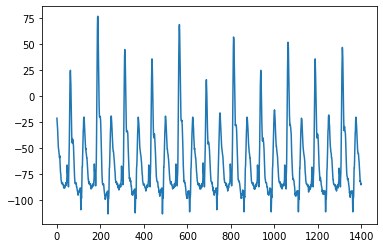

In [3]:
#%matplotlib widget
root =r"C:\Users\nampo\Downloads"
data = h5py.File(os.path.join(root,"ascad-variable.h5"), "r")

# The label has been chosen arbitrarily to be Sbox(plaintext[2] ^ key[2])
SUBKEY_INDEX = 2

# Show example
i = 69
label = data["Profiling_traces"]["labels"][i]
plaintext, key, masks, desync = data["Profiling_traces"]["metadata"][i]
trace = data["Profiling_traces"]["traces"][i]
print("label:       ", label)
print("plaintext:   ", plaintext)
print("key:         ", key)
print("masks:       ", masks)
print("desync:      ", desync)
assert(leakage_models.identity_sbox(plaintext[SUBKEY_INDEX], key[SUBKEY_INDEX]) == label)
plt.plot(trace)
plt.show()

## Part 1a: Extracting features 📐

In [4]:
train_traces = data["Profiling_traces"]["traces"]
train_plaintexts = data["Profiling_traces"]["metadata"]["plaintext"][:, SUBKEY_INDEX]
train_keys = data["Profiling_traces"]["metadata"]["key"][:, SUBKEY_INDEX]

num_train_traces, num_samples = train_traces.shape
print(f"Number of traces: {num_train_traces}, number of samples: {num_samples}")

# Check data shapes
assert(train_plaintexts.shape == (num_train_traces,))
assert(train_keys.shape == (num_train_traces,))

# Check that the keys are random and not all the same
assert(not np.all(train_keys[0] == train_keys[1]))

Number of traces: 200000, number of samples: 1400


In [5]:
#Not useful in case of deep learning template attacks

#from template_attack_utils import find_best_poi

# Compute the best points of interest
#labels = [LEAKAGE_MODEL(pt, k) for pt, k in zip(train_plaintexts, train_keys)]
#poi_indices = find_best_poi(train_traces, labels, NUM_FEATURES)

#print(poi_indices)

In [6]:
#Deep-learning model finding best POI

reconstructed_model = tk.models.load_model(os.path.join(root,'mymodel20.h5'), compile=False)


## Part 1b: Profiling 📊

In [7]:
features = []

batch_size = 4096
# Prepare the training dataset.
train_dataset = tf.data.Dataset.from_tensor_slices((train_traces, train_keys))
train_dataset = train_dataset.batch(batch_size)

for step,(x_batch,labels) in enumerate(train_dataset):
    features.append(reconstructed_model.predict(x_batch))
    
features = np.concatenate(features,axis = 0)
print(features.shape)

106/106 [==============================] - 1s 11ms/step
(200000, 32)


In [8]:
from template_attack_utils import make_template_foreach_label

# Extract the points of interest
#features = train_traces[:, poi_indices]
print(features.shape)

# Compute the templates
labels = [LEAKAGE_MODEL(pt, k) for pt, k in zip(train_plaintexts, train_keys)]
templates = make_template_foreach_label(features, labels)

print("Template construction done.")

(200000, 32)
Template construction done.


## Part 2: Attacking 💣

In [9]:
test_traces = data["Attack_traces"]["traces"]
test_plaintexts = data["Attack_traces"]["metadata"]["plaintext"][:, SUBKEY_INDEX]
test_keys = data["Attack_traces"]["metadata"]["key"][:, SUBKEY_INDEX]

num_test_traces, num_samples = test_traces.shape
print(f"Number of traces: {num_test_traces}, number of samples: {num_samples}")

# Check data shapes
assert(test_plaintexts.shape == (num_test_traces,))
assert(test_keys.shape == (num_test_traces,))

# Extraction of the secret key (must be the same for all traces)
SECRET_KEY = test_keys[0]
assert(np.all(test_keys == SECRET_KEY))

print(f"Secret key is {SECRET_KEY:#04x}")

Number of traces: 100000, number of samples: 1400
Secret key is 0x22


  0%|                                                                                           | 0/98 [00:00<?, ?it/s]

32/32 [==============================] - 1s 12ms/step


  1%|▊                                                                                | 1/98 [01:14<2:00:15, 74.39s/it]

32/32 [==============================] - 0s 11ms/step


  2%|█▋                                                                               | 2/98 [02:29<1:59:14, 74.53s/it]

32/32 [==============================] - 0s 12ms/step


  3%|██▍                                                                              | 3/98 [03:46<2:00:00, 75.79s/it]

32/32 [==============================] - 0s 13ms/step


  4%|███▎                                                                             | 4/98 [05:12<2:05:05, 79.85s/it]

32/32 [==============================] - 1s 17ms/step


  5%|████▏                                                                            | 5/98 [06:38<2:07:08, 82.03s/it]

32/32 [==============================] - 0s 11ms/step


  6%|████▉                                                                            | 6/98 [08:01<2:06:29, 82.50s/it]

32/32 [==============================] - 1s 18ms/step


  7%|█████▊                                                                           | 7/98 [09:31<2:08:50, 84.95s/it]

32/32 [==============================] - 1s 20ms/step


  8%|██████▌                                                                          | 8/98 [11:11<2:14:34, 89.72s/it]

32/32 [==============================] - 1s 19ms/step


  9%|███████▍                                                                         | 9/98 [12:51<2:17:59, 93.03s/it]

32/32 [==============================] - 1s 19ms/step


 10%|████████▏                                                                       | 10/98 [14:31<2:19:19, 94.99s/it]

32/32 [==============================] - 1s 19ms/step


 11%|████████▉                                                                       | 11/98 [16:01<2:15:30, 93.46s/it]

32/32 [==============================] - 0s 9ms/step


 12%|█████████▊                                                                      | 12/98 [17:17<2:06:22, 88.17s/it]

32/32 [==============================] - 0s 12ms/step


 13%|██████████▌                                                                     | 13/98 [18:32<1:59:26, 84.32s/it]

32/32 [==============================] - 0s 12ms/step


 14%|███████████▍                                                                    | 14/98 [19:47<1:54:08, 81.53s/it]

32/32 [==============================] - 0s 11ms/step


 15%|████████████▏                                                                   | 15/98 [21:02<1:50:00, 79.53s/it]

32/32 [==============================] - 0s 12ms/step


 16%|█████████████                                                                   | 16/98 [22:17<1:46:46, 78.13s/it]

32/32 [==============================] - 0s 12ms/step


 17%|█████████████▉                                                                  | 17/98 [23:37<1:46:22, 78.79s/it]

32/32 [==============================] - 1s 21ms/step


 18%|██████████████▋                                                                 | 18/98 [25:02<1:47:25, 80.57s/it]

32/32 [==============================] - 0s 10ms/step


 19%|███████████████▌                                                                | 19/98 [26:15<1:42:54, 78.16s/it]

32/32 [==============================] - 0s 10ms/step


 20%|████████████████▎                                                               | 20/98 [27:25<1:38:30, 75.77s/it]

32/32 [==============================] - 0s 10ms/step


 21%|█████████████████▏                                                              | 21/98 [28:37<1:35:37, 74.51s/it]

32/32 [==============================] - 0s 14ms/step


 22%|█████████████████▉                                                              | 22/98 [29:57<1:36:48, 76.43s/it]

32/32 [==============================] - 0s 10ms/step


 23%|██████████████████▊                                                             | 23/98 [31:09<1:33:42, 74.97s/it]

32/32 [==============================] - 0s 10ms/step


 24%|███████████████████▌                                                            | 24/98 [32:19<1:30:46, 73.60s/it]

32/32 [==============================] - 0s 9ms/step


 26%|████████████████████▍                                                           | 25/98 [33:30<1:28:19, 72.59s/it]

32/32 [==============================] - 0s 10ms/step


 27%|█████████████████████▏                                                          | 26/98 [34:40<1:26:15, 71.88s/it]

32/32 [==============================] - 0s 9ms/step


 28%|██████████████████████                                                          | 27/98 [35:50<1:24:30, 71.42s/it]

32/32 [==============================] - 0s 10ms/step


 29%|██████████████████████▊                                                         | 28/98 [37:03<1:23:58, 71.98s/it]

32/32 [==============================] - 0s 10ms/step


 30%|███████████████████████▋                                                        | 29/98 [38:15<1:22:36, 71.83s/it]

32/32 [==============================] - 0s 10ms/step


 31%|████████████████████████▍                                                       | 30/98 [39:25<1:20:39, 71.17s/it]

32/32 [==============================] - 0s 10ms/step


 32%|█████████████████████████▎                                                      | 31/98 [40:35<1:19:08, 70.88s/it]

32/32 [==============================] - 0s 9ms/step


 33%|██████████████████████████                                                      | 32/98 [41:45<1:17:37, 70.57s/it]

32/32 [==============================] - 0s 10ms/step


 34%|██████████████████████████▉                                                     | 33/98 [42:54<1:16:02, 70.20s/it]

32/32 [==============================] - 0s 10ms/step


 35%|███████████████████████████▊                                                    | 34/98 [44:04<1:14:47, 70.12s/it]

32/32 [==============================] - 0s 10ms/step


 36%|████████████████████████████▌                                                   | 35/98 [45:22<1:16:14, 72.61s/it]

32/32 [==============================] - 0s 10ms/step


 37%|█████████████████████████████▍                                                  | 36/98 [46:36<1:15:27, 73.02s/it]

32/32 [==============================] - 0s 14ms/step


 38%|██████████████████████████████▏                                                 | 37/98 [47:50<1:14:19, 73.11s/it]

32/32 [==============================] - 0s 10ms/step


 39%|███████████████████████████████                                                 | 38/98 [49:02<1:12:57, 72.96s/it]

32/32 [==============================] - 0s 10ms/step


 40%|███████████████████████████████▊                                                | 39/98 [50:15<1:11:37, 72.83s/it]

32/32 [==============================] - 0s 11ms/step


 41%|████████████████████████████████▋                                               | 40/98 [51:27<1:10:20, 72.77s/it]

32/32 [==============================] - 0s 10ms/step


 42%|█████████████████████████████████▍                                              | 41/98 [52:40<1:08:59, 72.62s/it]

32/32 [==============================] - 0s 10ms/step


 43%|██████████████████████████████████▎                                             | 42/98 [53:54<1:08:22, 73.26s/it]

32/32 [==============================] - 0s 10ms/step


 44%|███████████████████████████████████                                             | 43/98 [55:06<1:06:44, 72.81s/it]

32/32 [==============================] - 0s 10ms/step


 45%|███████████████████████████████████▉                                            | 44/98 [56:17<1:05:00, 72.23s/it]

32/32 [==============================] - 0s 10ms/step


 46%|████████████████████████████████████▋                                           | 45/98 [57:30<1:03:59, 72.44s/it]

32/32 [==============================] - 0s 11ms/step


 47%|█████████████████████████████████████▌                                          | 46/98 [58:53<1:05:31, 75.60s/it]

32/32 [==============================] - 0s 14ms/step


 48%|█████████████████████████████████████▍                                        | 47/98 [1:00:12<1:05:04, 76.56s/it]

32/32 [==============================] - 0s 10ms/step


 49%|██████████████████████████████████████▏                                       | 48/98 [1:01:23<1:02:31, 75.03s/it]

32/32 [==============================] - 0s 9ms/step


 50%|███████████████████████████████████████                                       | 49/98 [1:02:40<1:01:39, 75.50s/it]

32/32 [==============================] - 0s 12ms/step


 51%|███████████████████████████████████████▊                                      | 50/98 [1:03:55<1:00:18, 75.38s/it]

32/32 [==============================] - 0s 10ms/step


 52%|█████████████████████████████████████████▋                                      | 51/98 [1:05:08<58:29, 74.66s/it]

32/32 [==============================] - 0s 11ms/step


 53%|██████████████████████████████████████████▍                                     | 52/98 [1:06:24<57:29, 74.99s/it]

32/32 [==============================] - 0s 10ms/step


 54%|███████████████████████████████████████████▎                                    | 53/98 [1:07:38<56:06, 74.81s/it]

32/32 [==============================] - 0s 14ms/step


 55%|████████████████████████████████████████████                                    | 54/98 [1:08:59<56:15, 76.73s/it]

32/32 [==============================] - 0s 15ms/step


 56%|████████████████████████████████████████████▉                                   | 55/98 [1:10:15<54:42, 76.35s/it]

32/32 [==============================] - 0s 10ms/step


 57%|█████████████████████████████████████████████▋                                  | 56/98 [1:11:28<52:52, 75.54s/it]

32/32 [==============================] - 0s 10ms/step


 58%|██████████████████████████████████████████████▌                                 | 57/98 [1:12:43<51:24, 75.23s/it]

32/32 [==============================] - 0s 12ms/step


 59%|███████████████████████████████████████████████▎                                | 58/98 [1:13:59<50:24, 75.60s/it]

32/32 [==============================] - 0s 9ms/step


 60%|████████████████████████████████████████████████▏                               | 59/98 [1:15:15<49:06, 75.55s/it]

32/32 [==============================] - 0s 10ms/step


 61%|████████████████████████████████████████████████▉                               | 60/98 [1:16:29<47:39, 75.25s/it]

32/32 [==============================] - 0s 11ms/step


 62%|█████████████████████████████████████████████████▊                              | 61/98 [1:17:45<46:24, 75.27s/it]

32/32 [==============================] - 0s 10ms/step


 63%|██████████████████████████████████████████████████▌                             | 62/98 [1:19:01<45:22, 75.63s/it]

32/32 [==============================] - 0s 11ms/step


 64%|███████████████████████████████████████████████████▍                            | 63/98 [1:20:15<43:51, 75.18s/it]

32/32 [==============================] - 0s 11ms/step


 65%|████████████████████████████████████████████████████▏                           | 64/98 [1:21:28<42:14, 74.56s/it]

32/32 [==============================] - 0s 10ms/step


 66%|█████████████████████████████████████████████████████                           | 65/98 [1:22:44<41:09, 74.83s/it]

32/32 [==============================] - 0s 9ms/step


 67%|█████████████████████████████████████████████████████▉                          | 66/98 [1:23:58<39:46, 74.59s/it]

32/32 [==============================] - 0s 9ms/step


 68%|██████████████████████████████████████████████████████▋                         | 67/98 [1:25:11<38:21, 74.23s/it]

32/32 [==============================] - 0s 9ms/step


 69%|███████████████████████████████████████████████████████▌                        | 68/98 [1:26:23<36:42, 73.41s/it]

32/32 [==============================] - 0s 10ms/step


 70%|████████████████████████████████████████████████████████▎                       | 69/98 [1:27:35<35:15, 72.95s/it]

32/32 [==============================] - 0s 10ms/step


 71%|█████████████████████████████████████████████████████████▏                      | 70/98 [1:28:46<33:50, 72.53s/it]

32/32 [==============================] - 0s 12ms/step


 72%|█████████████████████████████████████████████████████████▉                      | 71/98 [1:30:00<32:46, 72.83s/it]

32/32 [==============================] - 0s 9ms/step


 73%|██████████████████████████████████████████████████████████▊                     | 72/98 [1:31:15<31:51, 73.51s/it]

32/32 [==============================] - 0s 11ms/step


 74%|███████████████████████████████████████████████████████████▌                    | 73/98 [1:32:30<30:48, 73.93s/it]

32/32 [==============================] - 0s 10ms/step


 76%|████████████████████████████████████████████████████████████▍                   | 74/98 [1:33:42<29:22, 73.42s/it]

32/32 [==============================] - 0s 9ms/step


 77%|█████████████████████████████████████████████████████████████▏                  | 75/98 [1:34:57<28:19, 73.90s/it]

32/32 [==============================] - 0s 10ms/step


 78%|██████████████████████████████████████████████████████████████                  | 76/98 [1:36:21<28:10, 76.84s/it]

32/32 [==============================] - 0s 10ms/step


 79%|██████████████████████████████████████████████████████████████▊                 | 77/98 [1:37:35<26:39, 76.15s/it]

32/32 [==============================] - 0s 12ms/step


 80%|███████████████████████████████████████████████████████████████▋                | 78/98 [1:38:48<25:02, 75.13s/it]

32/32 [==============================] - 0s 10ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 79/98 [1:40:01<23:35, 74.52s/it]

32/32 [==============================] - 0s 9ms/step


 82%|█████████████████████████████████████████████████████████████████▎              | 80/98 [1:41:18<22:35, 75.29s/it]

32/32 [==============================] - 0s 15ms/step


 83%|██████████████████████████████████████████████████████████████████              | 81/98 [1:42:32<21:14, 74.98s/it]

32/32 [==============================] - 0s 10ms/step


 84%|██████████████████████████████████████████████████████████████████▉             | 82/98 [1:43:44<19:43, 73.94s/it]

32/32 [==============================] - 0s 10ms/step


 85%|███████████████████████████████████████████████████████████████████▊            | 83/98 [1:44:56<18:22, 73.47s/it]

32/32 [==============================] - 0s 11ms/step


 86%|████████████████████████████████████████████████████████████████████▌           | 84/98 [1:46:18<17:44, 76.07s/it]

32/32 [==============================] - 0s 13ms/step


 87%|█████████████████████████████████████████████████████████████████████▍          | 85/98 [1:47:33<16:23, 75.62s/it]

32/32 [==============================] - 1s 18ms/step


 88%|██████████████████████████████████████████████████████████████████████▏         | 86/98 [1:48:46<14:59, 74.92s/it]

32/32 [==============================] - 0s 10ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 87/98 [1:49:59<13:37, 74.29s/it]

32/32 [==============================] - 0s 12ms/step


 90%|███████████████████████████████████████████████████████████████████████▊        | 88/98 [1:51:13<12:21, 74.12s/it]

32/32 [==============================] - 0s 10ms/step


 91%|████████████████████████████████████████████████████████████████████████▋       | 89/98 [1:52:25<11:01, 73.51s/it]

32/32 [==============================] - 0s 10ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 90/98 [1:53:37<09:45, 73.19s/it]

32/32 [==============================] - 0s 9ms/step


 93%|██████████████████████████████████████████████████████████████████████████▎     | 91/98 [1:54:49<08:28, 72.62s/it]

32/32 [==============================] - 0s 10ms/step


 94%|███████████████████████████████████████████████████████████████████████████     | 92/98 [1:56:00<07:12, 72.14s/it]

32/32 [==============================] - 0s 9ms/step


 95%|███████████████████████████████████████████████████████████████████████████▉    | 93/98 [1:57:11<05:59, 71.90s/it]

32/32 [==============================] - 0s 10ms/step


 96%|████████████████████████████████████████████████████████████████████████████▋   | 94/98 [1:58:22<04:47, 71.79s/it]

32/32 [==============================] - 0s 10ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 95/98 [1:59:37<03:37, 72.59s/it]

32/32 [==============================] - 0s 10ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 96/98 [2:00:52<02:26, 73.35s/it]

32/32 [==============================] - 0s 9ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▏| 97/98 [2:02:05<01:13, 73.12s/it]

21/21 [==============================] - 0s 9ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 98/98 [2:02:52<00:00, 75.23s/it]


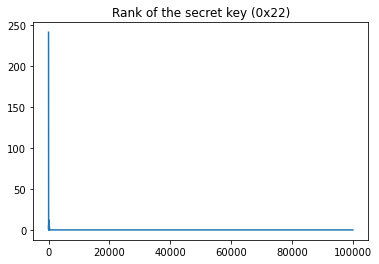

In [10]:
#%matplotlib widget

# Keep track of the rank of the secret key among the guesses. The goal is for the rank to reach zero
rank_of_secret_key = []

batch_size = 1024
attack_dataset = tf.data.Dataset.from_tensor_slices((test_plaintexts, test_traces))
attack_dataset = attack_dataset.batch(batch_size)

key_probabilities = np.zeros(256)
for pt, trace in tqdm(attack_dataset, total=len(attack_dataset)):
    # Extract the points of interest
    #feature_vector = trace[poi_indices]
    trace = trace[:,:,np.newaxis]
    feature_vector = reconstructed_model.predict(trace)
    
    for i in range(feature_vector.shape[0]):
        # Compute the probabilities for each label
        label_probabilities = {label: template.predict(feature_vector[i,:]) for label, template in templates.items()}

        # Update the key probabilities
        for k in range(256):
            key_probabilities[k] += label_probabilities[LEAKAGE_MODEL(pt[i], k)]

        # Get the rank of the secret key
        rank_of_secret_key.append(np.count_nonzero(key_probabilities > key_probabilities[SECRET_KEY]))

plt.plot(rank_of_secret_key)
plt.title(f"Rank of the secret key ({SECRET_KEY:#04x})")
plt.show()

In [15]:
#print(rank_of_secret_key)
first = np.where(np.array(rank_of_secret_key) == 0)
print(first)

(array([   45,    46,    47, ..., 99997, 99998, 99999], dtype=int64),)


In [22]:
print(len(rank_of_secret_key))

100000


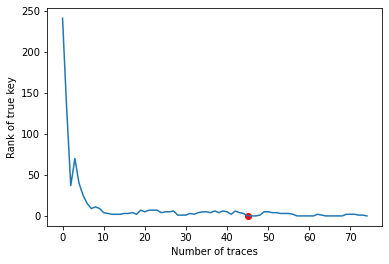

In [19]:
plt.plot(rank_of_secret_key[:first[0]*2])
plt.ylabel("Rank of true key")
plt.xlabel("Number of traces")
plt.scatter(first[0],rank_of_secret_key[first[0]], c="red")